# Etapa 2: Pré processamento dos dados

O objetivo desta etapa é realizar uma preparação lógica dos dados:
- leitura do CSV
- geração de rótulos numéricos de faixa etária (considerando que os rótulos atuais são categorizados em strings de faixa etária)
- salvar um DataFrame limpo para ser usado nos próximos notebooks.

In [53]:
# Importação das bibliotecas
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [54]:
# Caminhos para dados e rótulos
DATA_DIR = "../data/FairFace"

# Carregar dados
df = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))
print("Número total de imagens:", len(df))
print("Colunas disponíveis:", list(df.columns))

# Visualizar primeiras linhas
print("Primeiras linhas: ", df.head())

Número total de imagens: 86744
Colunas disponíveis: ['file', 'age', 'gender', 'race', 'service_test']
Primeiras linhas:            file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True


Faixa etária: 50-59


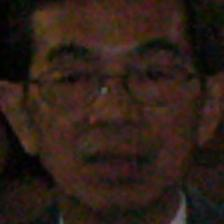

Faixa etária: 30-39


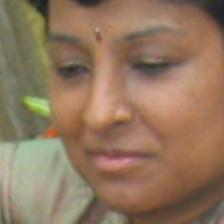

Faixa etária: 3-9


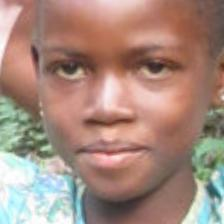

In [55]:
# Visulização de algumas imagens para validação manual
from PIL import Image
from IPython.display import display

for i in range(3):
    img_path = os.path.join(DATA_DIR, df['file'].iloc[i])
    img = Image.open(img_path)
    print(f"Faixa etária: {df['age'].iloc[i]}")
    display(img)

# Mapeamento de faixas etárias para índices numéricos

Os rótulos (exemplo: 20-29) são do tipo string e, a rede precisa que eles sejam inteiros (ou vetores one-hot). Portanto, para isso fazemos:
A rede precisa que os rótulos sejam números inteiros ou vetores one-hot. Para isso é preciso:
- Identificar das categorias únicas de faixa etária
- Atribuir um índice numérico para cada faixa
- Mapear a coluna "age" para uma nova coluna "label"

** NUM_CLASSES representa o número total de classes (usado na saída da rede)

In [56]:
# Ordem das faixas etárias
ordered_ages = ["0-2", "3-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "more than 70"]

# Mapear faixas etárias para rótulos numéricos
age_to_index = {age: idx for idx, age in enumerate(ordered_ages)}
df['label'] = df['age'].map(age_to_index)
print("\n Rótulos numéricos criados:")
print(df[['age', 'label']].drop_duplicates().sort_values('label'))


 Rótulos numéricos criados:
              age  label
18            0-2      0
2             3-9      1
8           10-19      2
3           20-29      3
1           30-39      4
6           40-49      5
0           50-59      6
14          60-69      7
107  more than 70      8


# Divisão entre treino, validação e teste
Embora os dados baixados via Kaggle já estejam divididos entre treino (88%) e validação (12%) como visto na etapa de análise exploratória, contudo é uma boa prática de desenvolvimento re-dividir o conjunto de treinamento para fazer validação interna.
A ideia é testar o modelo final utilizando o conjunto de validação como uma validação final.

<!-- Para fazer a divisão de forma automática e rápida, o ImageDataGenerator também permite com o parâmetro validation_split. -->

A escolha da separação do conjunto de teste foi pensada estrategicamente. Ao invés de separar de forma equilibrada entre faixas etárias, considerou-se que o dataset já possui um viés de faixa etária (como visto na análise exploratória) para idades entre 20-29 anos e 30-39 anos.
Sendo assim, a escolha foi uma estratégia baseada na frequência das classes, ou seja, de forma a priorizar a presença das classes menos representadas no conjunto de teste, permitindo uma avaliação mais rigorosa da performance do modelo em casos menos frequentes, como por exemplo, 0-2 anos.

Essa abordagem busca avaliar a capacidade de generalização do modelo em cenários desbalanceados, favorecendo uma análise mais justa e informativa do desempenho por faixa etária.


 Frequência relativa por faixa etária:
age
0-2             0.020658
3-9             0.119985
10-19           0.104941
20-29           0.295098
30-39           0.221917
40-49           0.123859
50-59           0.071797
60-69           0.032037
more than 70    0.009707
Name: proportion, dtype: float64

 Número de imagens a serem incluídas no conjunto de teste (ajustado pela raridade):
0-2         : 61 imagens (disponível: 1792)
3-9         : 33 imagens (disponível: 10408)
10-19       : 34 imagens (disponível: 9103)
20-29       : 30 imagens (disponível: 25598)
30-39       : 30 imagens (disponível: 19250)
40-49       : 33 imagens (disponível: 10744)
50-59       : 37 imagens (disponível: 6228)
60-69       : 49 imagens (disponível: 2779)
more than 70: 100 imagens (disponível: 842)


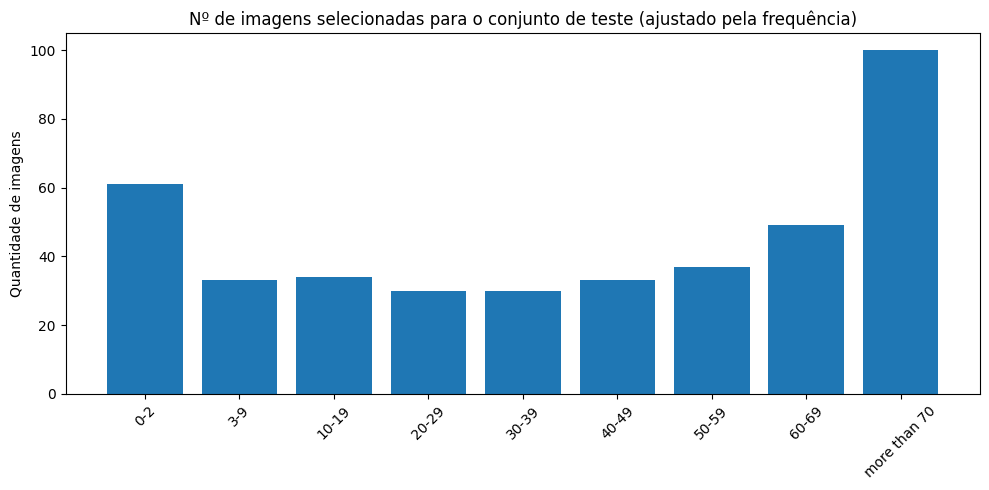

In [57]:
# Frequência relativa de cada faixa etária
frequencias = df['age'].value_counts(normalize=True).reindex(ordered_ages)
print("\n Frequência relativa por faixa etária:")
print(frequencias)

# Cálculo dos pesos inversos (quanto mais rara a classe, maior o peso)
pesos_inversos = 1 / frequencias

# Normalização para gerar nº de imagens entre min_imgs e max_imgs
min_imgs = 30
max_imgs = 100
pesos_normalizados = (pesos_inversos - pesos_inversos.min()) / (pesos_inversos.max() - pesos_inversos.min())
num_imgs_teste = (pesos_normalizados * (max_imgs - min_imgs) + min_imgs).astype(int)

# Mostrar número calculado de imagens por faixa etária para o conjunto de teste
print("\n Número de imagens a serem incluídas no conjunto de teste (ajustado pela raridade):")
for faixa in ordered_ages:
    disponivel = df[df['age'] == faixa].shape[0]
    escolhido = min(num_imgs_teste[faixa], disponivel)
    print(f"{faixa:12s}: {escolhido} imagens (disponível: {disponivel})")

# Visualização do número de imagens por classe para o conjunto de teste
plt.figure(figsize=(10, 5))
plt.bar(num_imgs_teste.index, [min(num_imgs_teste[faixa], df[df['age'] == faixa].shape[0]) for faixa in ordered_ages])
plt.title("Nº de imagens selecionadas para o conjunto de teste (ajustado pela frequência)")
plt.ylabel("Quantidade de imagens")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:

# Garantir que não selecione mais imagens do que o disponível
num_imgs_teste_final = {
    classe: min(num, df[df['age'] == classe].shape[0])
    for classe, num in num_imgs_teste.items()
}

# Construir o conjunto de teste com base na amostragem proporcional inversa
df_test_final = pd.concat([
    df[df['age'] == classe].head(num_imgs_teste_final[classe])
    for classe in ordered_ages
])

print("\nConjunto de teste montado com", len(df_test_final), "imagens.")


Conjunto de teste montado com 407 imagens.


In [59]:
# Remover as imagens de teste do conjunto total
df_restante = df.drop(df_test_final.index)

# Dividir o restante em treino e validação (85% / 15%), mantendo proporção entre classes
df_train, df_val = train_test_split(
    df_restante,
    test_size=0.15,
    stratify=df_restante['label'],
    random_state=42
)

# Mostrar tamanhos finais dos conjuntos
print("\nTamanhos finais dos conjuntos:")
print("Treino:", len(df_train))
print("Validação:", len(df_val))
print("Teste:", len(df_test_final))


Tamanhos finais dos conjuntos:
Treino: 73386
Validação: 12951
Teste   : 407


# Salva o dataframe processado para utilização nos próximos notebooks

In [63]:

SPLITS_DIR = "../splits"

df_train.to_csv(os.path.join(SPLITS_DIR, "train_split.csv"), index=False)
df_val.to_csv(os.path.join(SPLITS_DIR, "val_split.csv"), index=False)
df_test_final.to_csv(os.path.join(SPLITS_DIR, "test_split_final.csv"), index=False)
print("DataFrames com rótulos numéricos salvos com sucesso em: ", SPLITS_DIR)

DataFrames com rótulos numéricos salvos com sucesso em:  ../splits


# Visualizar distribuição de classes

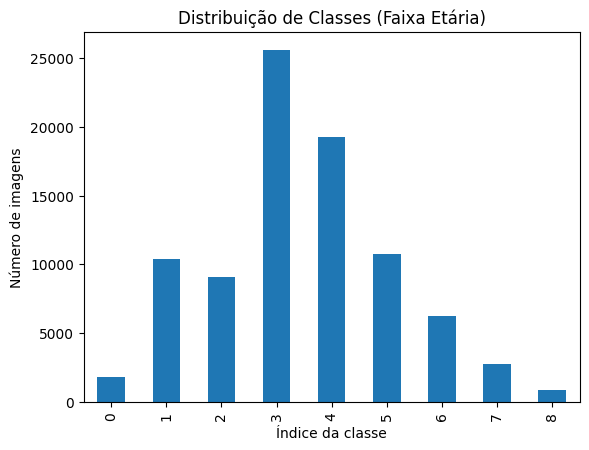

In [62]:
df['label'].value_counts().sort_index().plot(kind='bar', title='Distribuição de Classes (Faixa Etária)')
plt.xlabel("Índice da classe")
plt.ylabel("Número de imagens")
plt.show()